In [9]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models

In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"

train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname="split")# , sample_count=1000)

train_df.shape, val_df.shape

((39213, 10), (9803, 10))

In [3]:

kmer_length=5
max_length=410
batch_size=1024

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class CNNModel(nn.Module):
    def __init__(self, dataset, embedding_dim, num_filters, kernel_size, dropout_rate=0.5):
        super(CNNModel, self).__init__()
        self.kmer_count = len(dataset.kmer_to_index)

        self.kmer_embedding = nn.Embedding(self.kmer_count, embedding_dim)

        # Convolutional layer
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding='same')

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Linear layer
        self.linear = nn.Linear(in_features=num_filters, out_features=1)

    def forward(self, encoded_parents, masks):
        kmer_embeds = self.kmer_embedding(encoded_parents)
        kmer_embeds = kmer_embeds.permute(0, 2, 1)  # Transpose for Conv1D

        # Apply convolutional layer
        conv_out = F.relu(self.conv(kmer_embeds))

        # Apply dropout
        conv_out = self.dropout(conv_out)

        conv_out = conv_out.permute(0, 2, 1)  # Transpose back for Linear layer

        # Apply linear layer
        log_rates = self.linear(conv_out).squeeze(-1)

        # Exponentiate to get rates
        rates = torch.exp(log_rates * masks)

        return rates


In [5]:
def train_and_evaluate(model_name, model_instance, epochs=100, batch_size=1024, learning_rate=0.1, min_learning_rate=1e-4, l2_regularization_coeff=1e-6):
    print(f"Training {model_name}...")
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, batch_size=batch_size, learning_rate=learning_rate, min_learning_rate=min_learning_rate, l2_regularization_coeff=l2_regularization_coeff, verbose=True)
    
    # Train the model and get the history
    train_history = burrito.train(epochs=epochs)

    # Get initial and final losses
    initial_train_loss = train_history['train_loss'].iloc[0]
    initial_val_loss = train_history['val_loss'].iloc[0]
    final_train_loss = train_history['train_loss'].iloc[-1]
    final_val_loss = train_history['val_loss'].iloc[-1]

    # Record pre-training and post-training losses
    results = [
        {'model': model_name, 'trained': 'No', 'train_loss': initial_train_loss, 'val_loss': initial_val_loss},
        {'model': model_name, 'trained': 'Yes', 'train_loss': final_train_loss, 'val_loss': final_val_loss}
    ]
    return results

# Model instances
model_instances = {
    "fivemer": models.FivemerModel(train_dataset),
    "shmoof": models.SHMoofModel(train_dataset),
    "cnn_dropout": CNNModel(train_dataset, embedding_dim=12, num_filters=13, kernel_size=7, dropout_rate=0.1),
    "cnn": CNNModel(train_dataset, embedding_dim=12, num_filters=13, kernel_size=7, dropout_rate=0.0)
}

# DataFrame to hold results
results_list = []

# Iterate over models and gather results
for model_name, model_instance in model_instances.items():
    results = train_and_evaluate(model_name, model_instance)
    # append the results, which are a list, to the results_list. we can't do list.append because that would make a list of lists
    results_list.extend(results)

results_df = pd.DataFrame(results_list)
results_df.to_clipboard(index=False)


Training fivemer...
Epoch [0/100]	 Loss: 0.07508489	 Val Loss: 0.076426644
Epoch [1/100]	 Loss: 0.063793203	 Val Loss: 0.062123825
Epoch [2/100]	 Loss: 0.060967424	 Val Loss: 0.062012942
Epoch [3/100]	 Loss: 0.060933574	 Val Loss: 0.061984971
Epoch [4/100]	 Loss: 0.060937952	 Val Loss: 0.061992313
Epoch [5/100]	 Loss: 0.060936248	 Val Loss: 0.062027244
Epoch [6/100]	 Loss: 0.060948846	 Val Loss: 0.062000705
Epoch [7/100]	 Loss: 0.060938622	 Val Loss: 0.061990274
Epoch [8/100]	 Loss: 0.060945055	 Val Loss: 0.062010882
Epoch 00008: reducing learning rate of group 0 to 2.0000e-02.
Epoch [9/100]	 Loss: 0.060869593	 Val Loss: 0.061932195
Epoch [10/100]	 Loss: 0.060830586	 Val Loss: 0.06192006
Epoch [11/100]	 Loss: 0.060825296	 Val Loss: 0.061921389
Epoch [12/100]	 Loss: 0.06082723	 Val Loss: 0.061924882
Epoch [13/100]	 Loss: 0.060826198	 Val Loss: 0.061919911
Epoch [14/100]	 Loss: 0.06082879	 Val Loss: 0.06192399
Epoch [15/100]	 Loss: 0.060829723	 Val Loss: 0.061922497
Epoch 00015: reducing

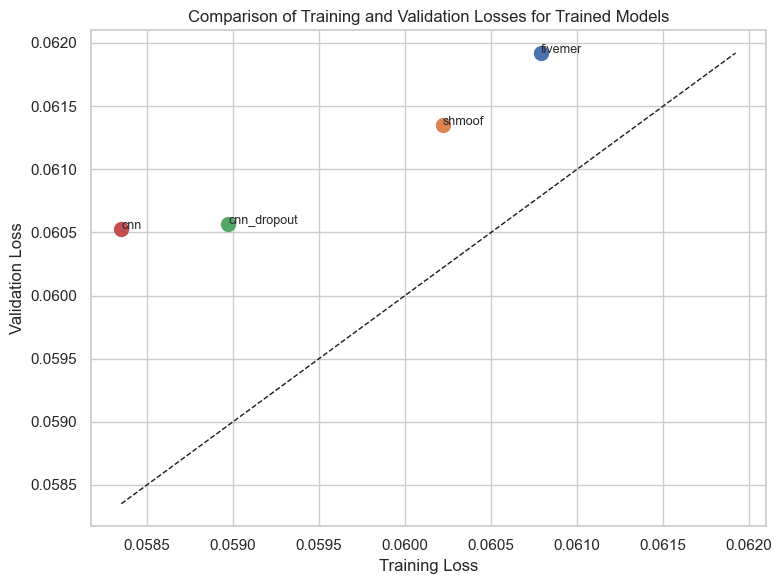

In [15]:
# Filter for only trained models
trained_models = results_df[results_df['trained'] == 'Yes']

# Set the aesthetics for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Scatter plot with direct labeling
for index, row in trained_models.iterrows():
    plt.scatter(row['train_loss'], row['val_loss'], label=row['model'], s=100)
    plt.text(row['train_loss'], row['val_loss'], row['model'], fontsize=9)

# # Plot x=y line
max_loss = max(trained_models['train_loss'].max(), trained_models['val_loss'].max())
min_loss = min(trained_models['train_loss'].min(), trained_models['val_loss'].min())
plt.plot([min_loss, max_loss],
         [min_loss, max_loss],
         'k--', lw=1, label='x = y')

# Adding additional details to the plot
plt.title('Comparison of Training and Validation Losses for Trained Models')
plt.xlabel('Training Loss')
plt.ylabel('Validation Loss')
# plt.legend(title='Reference')
plt.grid(True)
plt.tight_layout()

plt.show()